<h1><center>Lecture 8. Probabilistic Programing</center></h1>

<h4>About this Notebook</h4>
In this notebook, we learn how to use pymc3

taken from
<url>https://docs.pymc.io/notebooks/getting_started.html</url>

<h2>References</h2>
Patil, A., D. Huard and C.J. Fonnesbeck. (2010) PyMC: Bayesian Stochastic Modelling in Python. Journal of Statistical Software, 35(4), pp. 1-81

Bastien, F., Lamblin, P., Pascanu, R., Bergstra, J., Goodfellow, I., Bergeron, A., Bouchard, N., Warde-Farley, D., and Bengio, Y. (2012) “Theano: new features and speed improvements”. NIPS 2012 deep learning workshop.

Bergstra, J., Breuleux, O., Bastien, F., Lamblin, P., Pascanu, R., Desjardins, G., Turian, J., Warde-Farley, D., and Bengio, Y. (2010) “Theano: A CPU and GPU Math Expression Compiler”. Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX

Lunn, D.J., Thomas, A., Best, N., and Spiegelhalter, D. (2000) WinBUGS – a Bayesian modelling framework: concepts, structure, and extensibility. Statistics and Computing, 10:325–337.

Neal, R.M. Slice sampling. Annals of Statistics. (2003). doi:10.2307/3448413.

van Rossum, G. The Python Library Reference Release 2.6.5., (2010). URL http://docs.python.org/library/.

Duane, S., Kennedy, A. D., Pendleton, B. J., and Roweth, D. (1987) “Hybrid Monte Carlo”, Physics Letters, vol. 195, pp. 216-222.

Stan Development Team. (2014). Stan: A C++ Library for Probability and Sampling, Version 2.5.0. http://mc-stan.org.

Gamerman, D. Markov Chain Monte Carlo: statistical simulation for Bayesian inference. Chapman and Hall, 1997.

Hoffman, M. D., & Gelman, A. (2014). The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research, 30.

Kucukelbir A, Dustin Tran, Ranganath R, Gelman A, and Blei DM. Automatic differentiation variational inference http://arxiv.org/abs/1506.03431, The Journal of Machine Learning Research. 18 , pp. 430-474 .

Vanderplas, Jake. “Frequentism and Bayesianism IV: How to be a Bayesian in Python.” Pythonic Perambulations. N.p., 14 Jun 2014. Web. 27 May. 2015. https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/.

R.G. Jarrett. A note on the intervals between coal mining disasters. Biometrika, 66:191–193, 1979.

<h2> Abstract </h2>

Probabilistic Programming allows for automatic Bayesian inference on user-defined probabilistic models. Recent advances in Markov chain Monte Carlo (MCMC) sampling allow inference on increasingly complex models. This class of MCMC, known as Hamiltonian Monte Carlo, requires gradient information which is often not readily available. PyMC3 is a new open source Probabilistic Programming framework written in Python that uses Theano to compute gradients via automatic differentiation as well as compile probabilistic programs on-the-fly to C for increased speed. Contrary to other Probabilistic Programming languages, PyMC3 allows model specification directly in Python code. The lack of a domain specific language allows for great flexibility and direct interaction with the model. This paper is a tutorial-style introduction to this software package.

<h2>Introduction</h2>

Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC3 is a new, open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. It features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don’t need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC.

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

While most of PyMC3’s user-facing features are written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Theano is a library that allows expressions to be defined using generalized vector data structures called tensors, which are tightly integrated with the popular NumPy ndarray data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood’s computational graph for speed and provides simple GPU integration.

<h3>Installation</h3>

pip install pymc3

Or via conda:

conda install pymc3

<h3>Motivating example</h3>

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$.

$$
\begin{align}
Y &\sim \mathcal{N}(\mu,\sigma^2)\\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{align}
$$

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while $\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 10 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\alpha$.

$$
\begin{align}
\alpha & \sim \mathcal{N}(0,100)\\
\beta_i &\sim \mathcal{N}(0,100)\\
\sigma  & \sim  |\mathcal{N}(0,1)|
\end{align} 
$$

<h2>Generating the data</h2>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

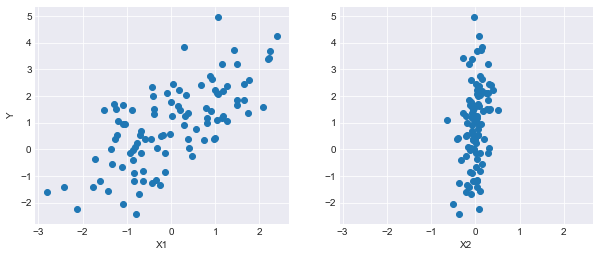

In [3]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

<h2>Model Specification</h2>

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

First, we import PyMC. We use the convention of importing it as pm.


In [4]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [5]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

The first line,

**basic_model = pm.Model()**
creates a new Model object which is a container for the model random variables.

Following instantiation of the model, the subsequent specification of the model components is performed inside a with statement:

with basic_model:
This creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with basic_model right after we create them. If you try to create a new random variable without a with model: statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:

**alpha = Normal('alpha', mu=0, sigma=10) <br>
eta = Normal('beta', mu=0, sigma=10, shape=2) <br>
sigma = HalfNormal('sigma', sigma=1)** <br>

We call the Normal constructor to create a random variable to use as a normal prior. The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case mu, the mean, and sd, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, are available in PyMC3.

The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. The shape argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix values).

Detailed notes about distributions, sampling methods and other PyMC3 functions are available in the API documentation.

Having defined the priors, the next statement creates the expected value mu of the outcomes, specifying the linear relationship:

**mu = alpha + beta[0]\*X1 + beta[1]\*X2**

This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the predictor variables, whatever their values may be.

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like sum, sin, exp and linear algebra functions like dot (for inner product) and inv (for inverse) are also provided.

The final line of the model, defines Y_obs, the sampling distribution of the outcomes in the dataset.

**Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)**


This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables.

<h2>Model fitting  </h2>

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the maximum a posteriori (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

<h2>Maximum a posteriori methods  </h2>

**The maximum a posteriori (MAP) estimate** for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

C:\ProgramData\Anaconda3\envs\stan\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 542.70it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

In summary, while PyMC3 provides the function find_MAP(), at this point mostly for historical reasons, this function is of little use in most scenarios. If you want a point estimate you should get it from the posterior. In the next section we will see how to get a posterior using sampling methods.

<h3>Sampling methods</h3>

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the true posterior distribution.

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

Binary variables will be assigned to BinaryMetropolis
Discrete variables will be assigned to Metropolis
Continuous variables will be assigned to NUTS
Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.

<h3>Gradient-based sampling methods</h3>

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument (see below for an example of how to explicitly assign step methods).

In [10]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:16<00:00, 120.40draws/s]


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

In [11]:
trace['alpha'][-5:]

array([0.86038143, 0.88875012, 0.91392392, 0.99143432, 0.86691189])

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [6]:
with basic_model:

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:26<00:00, 422.68draws/s]


<h3>Posterior analysis</h3>
PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using traceplot.

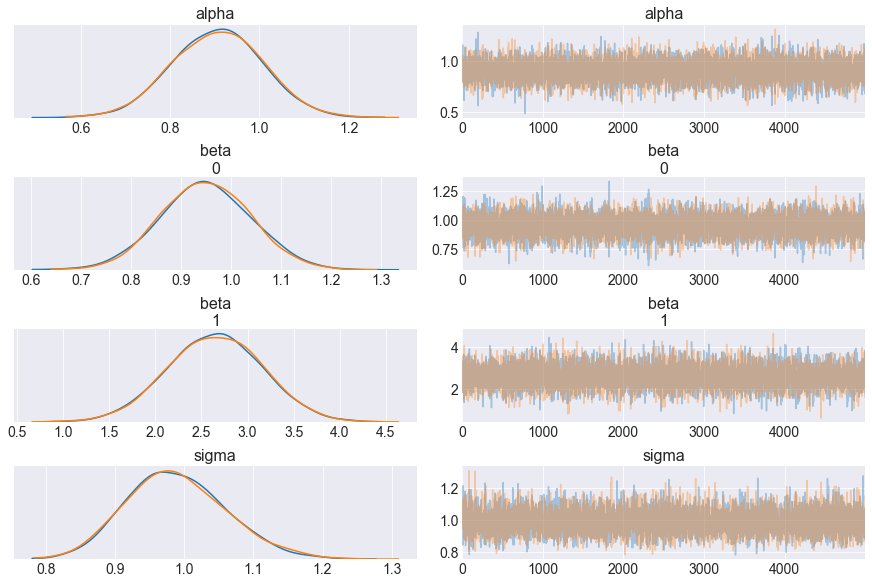

In [7]:
pm.traceplot(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [8]:
pm.summary(trace).round(2)

C:\ProgramData\Anaconda3\envs\stan\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.91,0.10,0.00,0.71,1.10,9174.60,1.0
beta__0,0.95,0.09,0.00,0.77,1.12,9355.20,1.0
beta__1,2.65,0.51,0.01,1.63,3.62,8478.11,1.0
sigma,0.99,0.07,0.00,0.86,1.13,9013.68,1.0


<h2>Case study 1: Stochastic volatility</h2>
We present a case study of stochastic volatility, time varying stock market volatility, to illustrate PyMC3’s use in addressing a more realistic problem. The distribution of market returns is highly non-normal, which makes sampling the volatilities significantly more difficult. This example has 400+ parameters so using common sampling algorithms like Metropolis-Hastings would get bogged down, generating highly autocorrelated samples. Instead, we use NUTS, which is dramatically more efficient.

<h2>The Model</h2>
Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others they are very stable. Stochastic volatility models address this with a latent volatility variable, which changes over time. The following model is similar to the one described in the NUTS paper (Hoffman 2014, p. 21).


$$
\begin{align}
\nu &\sim \exp(0.1)\\
\sigma &\sim \exp(50)\\
s_i &\sim \mathcal{N}(s_{i-1}, \sigma^2)\\
log(r_i) &\sim t(\nu,0,exp(-2s_i))
\end{align}
$$

Here, $r$ is the daily return series which is modeled with a Student-t distribution with an unknown degrees of freedom parameter, and a scale parameter determined by a latent process s. The individual si are the individual daily log volatilities in the latent log volatility process.

<h2>The Data</h2>
Our data consist of 401 daily returns of the S&P 500 stock market index during the 2008 financial crisis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


import pandas as pd

returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

len(returns)

NameError: name 'pm' is not defined

In [2]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

NameError: name 'returns' is not defined